# Kaooi Demo

In [ ]:
import IPython
_ipy = IPython.get_ipython()
_formatters = _ipy.display_formatter.formatters
_json_formatter = _formatters["application/json"]
_json_formatter.for_type(dict, lambda obj: obj)
_json_formatter.for_type(list, lambda obj: obj)

In [1]:
import kaooi
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
import pandas as pd
from hvplot import xarray, pandas
from dask.distributed import Client
import seaborn as sns
import holoviews as hv

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 32,Total memory: 62.79 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43501,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 32
Started: Just now,Total memory: 62.79 GiB
Comm: tcp://127.0.0.1:33819,Total threads: 4
Dashboard: http://127.0.0.1:39491/status,Memory: 7.85 GiB
Nanny: tcp://127.0.0.1:40863,


In [3]:
ds = kaooi.open_ooi_lf()

In [4]:
ds

<xarray.Dataset>
Dimensions:       (time: 1440001, transmission: 429)
Coordinates:
  * time          (time) float64 0.0 0.005 0.01 ... 7.2e+03 7.2e+03 7.2e+03
  * transmission  (transmission) datetime64[ns] 2023-03-18 ... 2024-02-11T20:...
Data variables:
    AXBA1         (time, transmission) float32 dask.array<chunksize=(1440001, 1), meta=np.ndarray>
    AXCC1         (time, transmission) float32 dask.array<chunksize=(1440001, 1), meta=np.ndarray>
    AXEC2         (time, transmission) float32 dask.array<chunksize=(1440001, 1), meta=np.ndarray>
    HYS14         (time, transmission) float32 dask.array<chunksize=(1440001, 1), meta=np.ndarray>
    HYSB1         (time, transmission) float32 dask.array<chunksize=(1440001, 1), meta=np.ndarray>

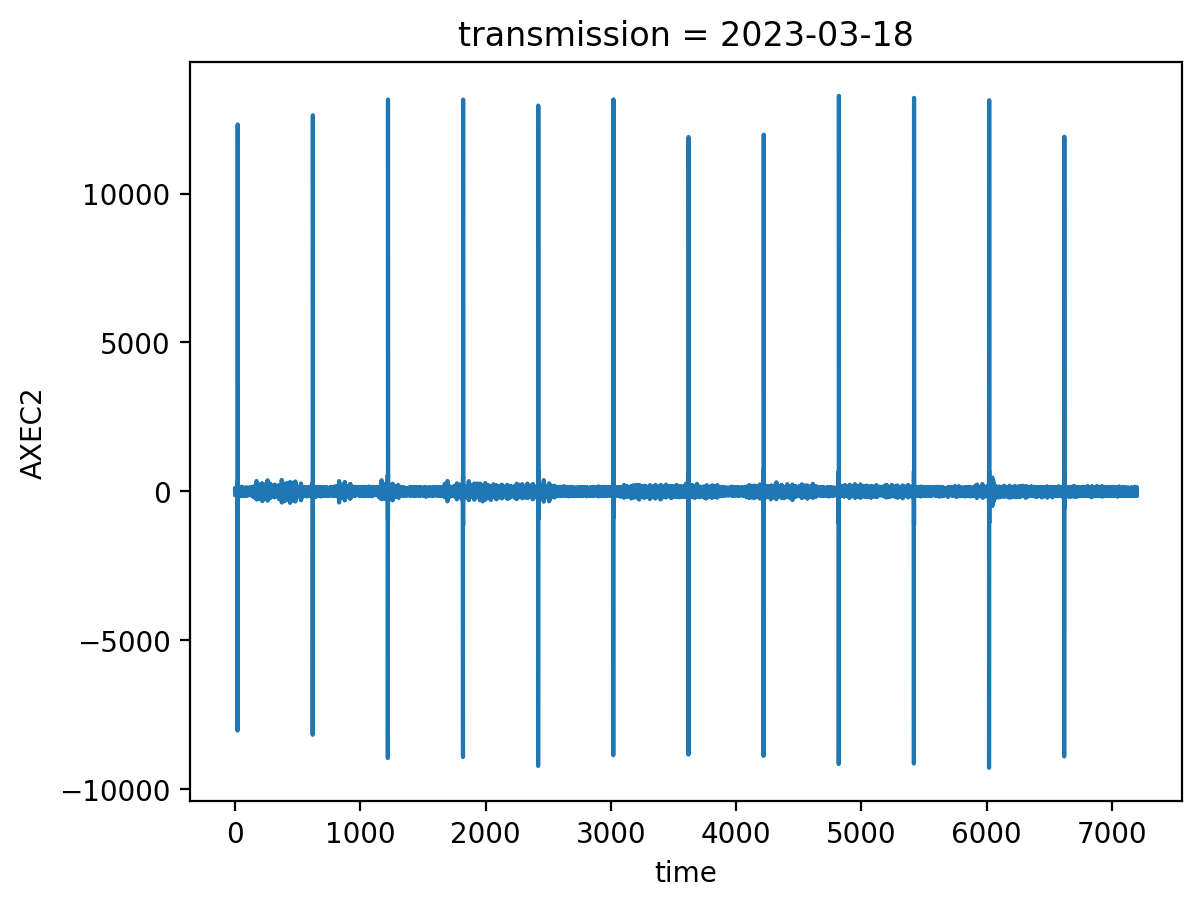

In [5]:
ds['AXEC2'][:,0].plot()

In [6]:
ds_proc = kaooi.process_data(ds, sampling_rate=200)

In [8]:
ds_proc

<xarray.Dataset>
Dimensions:       (longtime: 263, shorttime: 5456, transmission: 429)
Coordinates:
  * longtime      (longtime) float64 0.0 27.28 54.56 ... 7.12e+03 7.147e+03
  * shorttime     (shorttime) float64 0.0 0.005 0.01 0.015 ... 27.27 27.27 27.28
  * transmission  (transmission) datetime64[ns] 2023-03-18 ... 2024-02-11T20:...
Data variables:
    AXBA1         (transmission, longtime, shorttime) complex128 dask.array<chunksize=(1, 263, 5456), meta=np.ndarray>
    AXCC1         (transmission, longtime, shorttime) complex128 dask.array<chunksize=(1, 263, 5456), meta=np.ndarray>
    AXEC2         (transmission, longtime, shorttime) complex128 dask.array<chunksize=(1, 263, 5456), meta=np.ndarray>
    HYS14         (transmission, longtime, shorttime) complex128 dask.array<chunksize=(1, 263, 5456), meta=np.ndarray>
    HYSB1         (transmission, longtime, shorttime) complex128 dask.array<chunksize=(1, 263, 5456), meta=np.ndarray>

In [12]:
ds_stack = ds_proc.sel({'longtime':slice(41*60, 61*60)}).mean('longtime')

In [13]:
ds_stack

<xarray.Dataset>
Dimensions:       (shorttime: 5456, transmission: 429)
Coordinates:
  * shorttime     (shorttime) float64 0.0 0.005 0.01 0.015 ... 27.27 27.27 27.28
  * transmission  (transmission) datetime64[ns] 2023-03-18 ... 2024-02-11T20:...
Data variables:
    AXBA1         (transmission, shorttime) complex128 dask.array<chunksize=(1, 5456), meta=np.ndarray>
    AXCC1         (transmission, shorttime) complex128 dask.array<chunksize=(1, 5456), meta=np.ndarray>
    AXEC2         (transmission, shorttime) complex128 dask.array<chunksize=(1, 5456), meta=np.ndarray>
    HYS14         (transmission, shorttime) complex128 dask.array<chunksize=(1, 5456), meta=np.ndarray>
    HYSB1         (transmission, shorttime) complex128 dask.array<chunksize=(1, 5456), meta=np.ndarray>

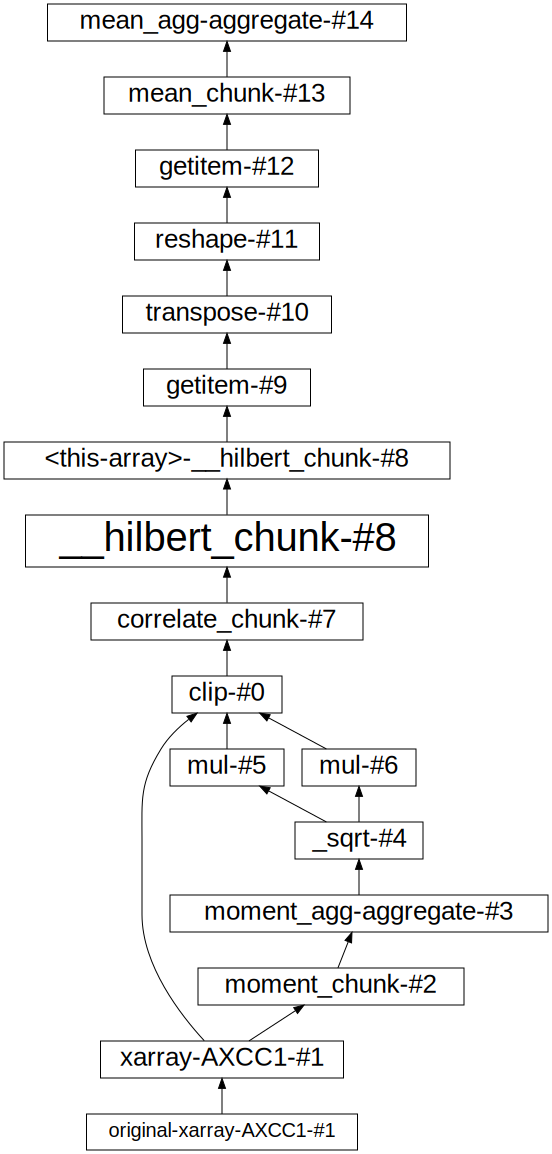

In [14]:
ds_stack['AXCC1'].data.dask.visualize()

In [15]:
single_node = np.abs(ds_stack['AXCC1']).compute()

/home/jhrag/miniconda3/envs/kb/lib/python3.11/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home/jhrag/miniconda3/envs/kb/lib/python3.11/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home/jhrag/miniconda3/envs/kb/lib/python3.11/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home/jhrag/miniconda3/envs/kb/lib/python3.11/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home/jhrag/miniconda3/envs/kb/lib/python3.11/site-packages/scipy/signal/_signaltools.py:243: RuntimeWarning: Use of fft convolution on input with NAN or inf results in NAN or inf output. Consider using method='direct' instead.
  return convolve(in1, _reverse_and_conj(in2), mode, method)
/home/jhrag/miniconda3/

## Plot smoothed reception (normalized to snr)

In [16]:
single_node_smoothed = single_node.rolling(shorttime=100).mean()

In [17]:
snr = 20*np.log10(single_node_smoothed / np.sqrt((single_node_smoothed**2).mean('shorttime')))

In [18]:
snr.hvplot(rasterize=True, cmap='mako_r')

:DynamicMap   []
   :Image   [transmission,shorttime]   (AXCC1)

In [19]:
peaks = kaooi.estimate_peaks_array(np.abs(single_node), snr_threshold=5, timestamp='date', flatten=True)

In [20]:
peaks

{'peak_times': array([ 0.225,  0.54 ,  0.555, ..., 25.82 , 26.46 , 26.81 ]),
 'snrs': array([7.45933214, 5.37183316, 5.8165232 , ..., 6.69825405, 5.51919325,
        5.79764352]),
 'Txs': DatetimeIndex(['2023-03-18 00:00:00', '2023-03-18 00:00:00',
                '2023-03-18 00:00:00', '2023-03-18 00:00:00',
                '2023-03-18 00:00:00', '2023-03-18 00:00:00',
                '2023-03-18 00:00:00', '2023-03-18 00:00:00',
                '2023-03-18 00:00:00', '2023-03-18 00:00:00',
                ...
                '2024-02-11 20:00:00', '2024-02-11 20:00:00',
                '2024-02-11 20:00:00', '2024-02-11 20:00:00',
                '2024-02-11 20:00:00', '2024-02-11 20:00:00',
                '2024-02-11 20:00:00', '2024-02-11 20:00:00',
                '2024-02-11 20:00:00', '2024-02-11 20:00:00'],
               dtype='datetime64[ns]', length=45289, freq=None)}

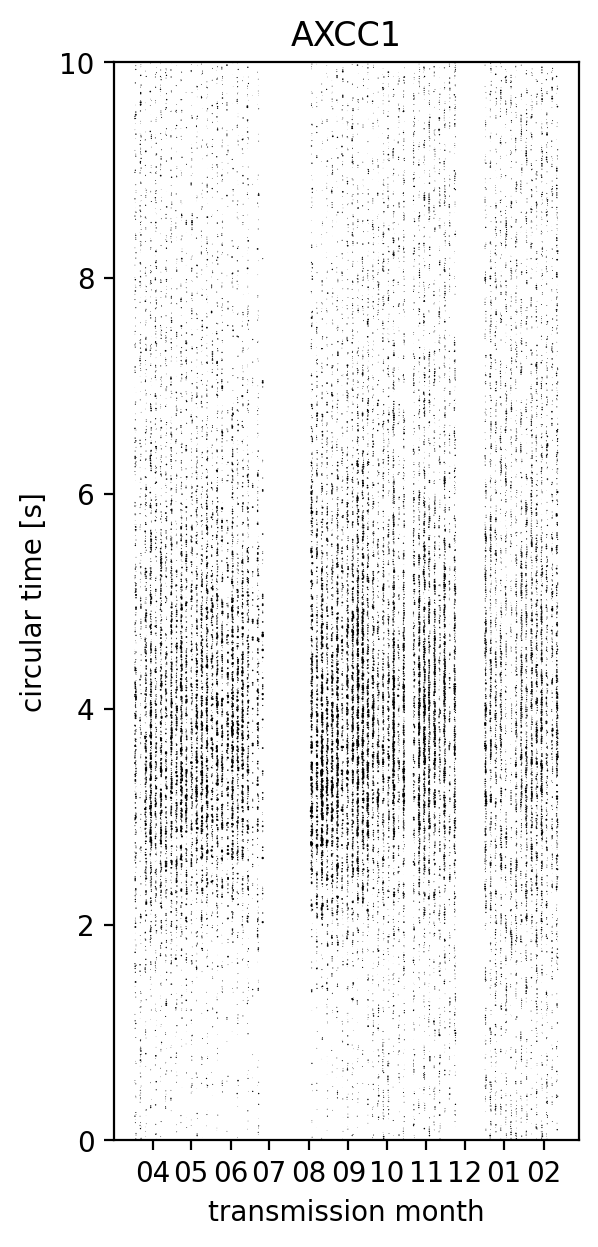

In [21]:
# plot peaks

peaks_df = pd.DataFrame(peaks)
peaks_df['s'] = (peaks_df['snrs'] - 5)/10
peaks_df.loc[peaks_df['s'] <0, 's'] = 0

fig = plt.figure(figsize=(3,7))
ax = plt.gca()
peaks_df.plot.scatter(x='Txs', y='peak_times', s='s', c='k', ax=ax, lw=0)
plt.ylim([0,10])
plt.ylabel('circular time [s]')
plt.xlabel('transmission month')
plt.title(single_node.name)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m'))

### hv plot

In [ ]:
peaks_df = pd.DataFrame(peaks)
peaks_df['s'] = (peaks_df['snrs'] - 3)/10

peaks_df.loc[peaks_df['s'] <0, 's'] = 0

peaks_df.hvplot.scatter(y='peak_times', x='Txs', c='k',  s='s', width=300, height=500)